# Assignment 2 - Epipolar Geometry and 3D Reconstruction 

First name:
<br>
Last name: 
<br>
Matriculation number:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

import numpy as np
from PIL import Image
import ipyvolume as ipv
import matplotlib.pyplot as plt

from utils import decompose_essential_matrix, infer_3d, ransac # get_euler_angles_and_translation

## Part II: 3D Model Reconstruction

### Load matched points
We provide a synthetic pair of images where noisy correspondences are known.

In [2]:
left = np.array(Image.open(os.path.join('MatchedPoints','left.jpg')), dtype=np.float32).mean(2)/255
right = np.array(Image.open(os.path.join('MatchedPoints','right.jpg')), dtype=np.float32).mean(2)/255

Text(0.5, 1.0, 'Right image')

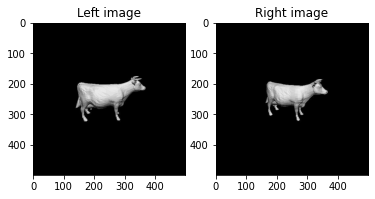

In [3]:
plt.subplot(1,2,1)
plt.imshow(left, cmap='gray')
plt.title('Left image')
plt.subplot(1,2,2)
plt.imshow(right, cmap='gray')
plt.title('Right image')

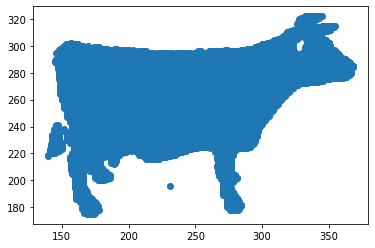

In [4]:
ilias_username = 'z.m.matti'
A = np.loadtxt(f'MatchedPoints/Matched_Points_{ilias_username}.txt')
# A = np.loadtxt(f'MatchedPoints/Matched_Points.txt') # clean data
M, N = A.shape
left_points = np.concatenate((A[:,2:4].T, np.ones((1, M))), axis=0)
right_points = np.concatenate((A[:,0:2].T, np.ones((1, M))), axis=0)
plt.scatter(left_points[0, :], left_points[1, :])

### Calibration matrix and focal length from the given file

In [5]:
fl = 4
K = np.array([
    [-83.33333, 0.00000, 250.00000],
    [0.00000, -83.33333, 250.00000],
    [0.00000, 0.00000,   1.00000],
])

I = K.copy()

I[0,0] *= fl
I[1,1] *= fl

### Estimate Essential matrix E from F with RANSAC

In [6]:
F, inliers = ransac(left_points, right_points, 0.1, 1000)
print('Num outliers', left_points.shape[1] - inliers.sum())
assert np.linalg.matrix_rank(F) == 2
print('Estimated fundamental matrix: ')
print(F)

E = I.T @ F @ I

print('Estimated essential matrix: ')
print(E)

(array([2746], dtype=int32),)
(array([2746], dtype=int32),)
(array([    0,     1,     2, ..., 12587, 12588, 12589], dtype=int32),)
(array([    0,     1,     2, ..., 12587, 12588, 12589], dtype=int32),)
(array([ 2746,  3836, 11490], dtype=int32),)
(array([    0,     1,     2, ..., 12587, 12588, 12589], dtype=int32),)
(array([    0,     1,     2, ..., 12587, 12588, 12589], dtype=int32),)
(array([ 2746,  3836, 11490], dtype=int32),)
(array([    0,     1,     2, ..., 12587, 12588, 12589], dtype=int32),)
(array([    0,     1,     2, ..., 12587, 12588, 12589], dtype=int32),)
(array([ 2746,  3836, 11490], dtype=int32),)
(array([    0,     1,     2, ..., 12587, 12588, 12589], dtype=int32),)
(array([    0,     1,     2, ..., 12587, 12588, 12589], dtype=int32),)
(array([ 2746,  3836, 11490], dtype=int32),)
(array([    0,     1,     2, ..., 12587, 12588, 12589], dtype=int32),)
(array([    0,     1,     2, ..., 12587, 12588, 12589], dtype=int32),)
(array([ 2746,  3836, 11490], dtype=int32),)
(arra

KeyboardInterrupt: 

### Compute rotation and translation between views

In [ ]:
# Compute Rotation and translation between views
Il = np.linalg.solve(I, left_points[:, inliers])
Ir = np.linalg.solve(I, right_points[:, inliers])

Pl, Pr = decompose_essential_matrix(E, Il, Ir)

print('Estimated translation: ')
print(Pr[:,3])
print('Estimated rotation: ')
print(Pr[:,:3])

### Estimate the 3D points

In [ ]:
x_3d = infer_3d(Il, Ir, Pl, Pr)
ipv.quickscatter(x=x_3d[0,:], y=x_3d[1,:], z=x_3d[2,:])

In [ ]:
R_XYZ_c_deg, tc = get_euler_angles_and_translation(Pr)

# Calculate exact solution from camera extrinsic parameters
# Rotation of the Right Camera with respect to world frame
Rr = np.array([[0.92848,  -0.12930,   0.34815],
               [0.00000,   0.93744,   0.34815],
               [-0.37139,  -0.32325,   0.87039]])

# Translation of the Right Camera with respect to world frame
tr = np.array([-2.0, 2.0, 5.0])

# Homogeneous transformation from Right camera to world
Tr_b = np.zeros((4,4))
Tr_b[0:3,0:3] = Rr
Tr_b[3,3] = 1
Tr_b[0:3,3] = tr

# Rotation of the Left Camera with respect to world frame
Rl = np.array([[1.00000,   0.00000,   0.00000],
               [0.00000,   0.92848,   0.37139],
               [0.00000,  -0.37139,   0.92848]])

# Translation of the Left Camera with respect to world frame
tl = np.array([0.0, 2.0, 5.0])

# Homogenious transformation from world to Left camera
Tb_l = np.zeros((4,4))
Tb_l[0:3,0:3] = Rl.T
Tb_l[3,3] = 1
Tb_l[0:3,3] =  - Rl.T @ tl

# Transformation from Right to Left camera frames
Tl_r = np.zeros((4,4))
Tl_r = Tb_l @ Tr_b

# As Pr is the inverse transformation, invert this the result
# in order to compare them
Tr_r = np.copy(Tl_r)
Tr_r[0:3,0:3] = Tl_r[0:3,0:3].T
Tr_r[0:3,3] = - Tl_r[0:3,0:3].T @ Tl_r[0:3,3]

R_XYZ_r_deg, tr = get_euler_angles_and_translation(Tr_r)
# Normalize translation in order to compare them
tr = tr[:3]
normalized_tr = tr/(np.sqrt(np.sum(np.square(tr))))

print('estimated rotation', R_XYZ_c_deg)
print('ground truth rotation', R_XYZ_r_deg)
print('estimated translation', tc)
print('ground truth translation', normalized_tr)

print('L1-Norm of the rotation error: {}'.format(np.sum(np.abs(R_XYZ_r_deg - R_XYZ_c_deg))))
print('L1-Norm of the translation error: {}'.format(np.sum(np.abs(normalized_tr - tc))))